<a href="https://colab.research.google.com/github/ElahehJafarigol/AMR-Benchmark/blob/main/GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic Modulation Classification

**MaxWav LLc**

Spring 2024

In this notebook we will explore some deep learning models to classify data based on their modulation type.

**Dataset:** RadioML 2026.10A

**Contributors:** Elaheh Jafarigol

###Imports

In [1]:
# Copy the file to the current directory.
!cp /content/drive/MyDrive/Colab_Notebooks/DeepSig/loader.py .

In [2]:
from loader import DataSet
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn
import random
import tensorflow as tf
import pickle
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from scipy.signal import spectrogram
np.random.seed(42)
tf.random.set_seed(1234)

In [3]:
# Load the dataset from the pickle file
dataset = DataSet('/content/drive/MyDrive/Colab_Notebooks/DeepSig/RML2016.10a_dict.dat')

dataset.normalize()

# Extract the data and labels
X = dataset.X
y = dataset.Y

# Normalize the data
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Convert labels to categorical
y = to_categorical(y, num_classes=11)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test, X_train_snr, X_test_snr = dataset.split()

def _reshape(X):
    """
    Reshape input data for CNN model.

    Args:
    - X: Input data with shape (num_samples, 2, 128)

    """
    return X.reshape((len(X), 128, 2))

X_train = _reshape(X_train)
X_test = _reshape(X_test)

X_train, X_val, y_train, y_val, X_train_snr, X_val_snr = train_test_split(X_train, y_train, X_train_snr, test_size=0.2)

In [4]:
# Hyperparameters
lr = 0.001
dr = 0.5
Epochs = 100
Batch_size = 400

# Parameters
optimizer=tf.keras.optimizers.Adam(learning_rate=lr, beta_1= 0.9 )
loss = "categorical_crossentropy"
metrics = ['accuracy']

input_shape = (128, 2)
num_classes = 11

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,Conv1D,MaxPool1D,ReLU,Dropout,Softmax
from tensorflow.keras.layers import Conv2D,concatenate,Flatten,Reshape,LeakyReLU,Subtract,GRU
from tensorflow.keras.layers import LSTM,AveragePooling2D,MaxPool2D,Add

In [6]:
input = Input(shape = input_shape, name='input1')

#LSTM Unit
x = GRU(units=128,return_sequences = True)(input)
x = GRU(units=128)(x)

#DNN
output = Dense(num_classes,activation='softmax',name='softmax')(x)

gru_model = Model(inputs = input,outputs = output)

gru_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input1 (InputLayer)         [(None, 128, 2)]          0         
                                                                 
 gru (GRU)                   (None, 128, 128)          50688     
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 softmax (Dense)             (None, 11)                1419      
                                                                 
Total params: 151179 (590.54 KB)
Trainable params: 151179 (590.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
# Compile the CNN model
gru_model.compile(optimizer = optimizer,
                  loss = loss,
                  metrics = metrics)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Start the timer
start = time.time()

# Train the model
history = gru_model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks = [early_stopping], epochs=Epochs, batch_size=Batch_size)

# End the timer
end = time.time()

Epoch 1/100
352/352 [==============================] - 12s 24ms/step - loss: 1.9350 - accuracy: 0.2787 - val_loss: 1.6803 - val_accuracy: 0.3701
Epoch 2/100
352/352 [==============================] - 8s 22ms/step - loss: 1.5827 - accuracy: 0.4152 - val_loss: 1.5082 - val_accuracy: 0.4418
Epoch 3/100
352/352 [==============================] - 8s 22ms/step - loss: 1.4554 - accuracy: 0.4629 - val_loss: 1.4297 - val_accuracy: 0.4662
Epoch 4/100
352/352 [==============================] - 8s 22ms/step - loss: 1.4035 - accuracy: 0.4811 - val_loss: 1.3757 - val_accuracy: 0.4860
Epoch 5/100
352/352 [==============================] - 8s 22ms/step - loss: 1.3745 - accuracy: 0.4918 - val_loss: 1.3520 - val_accuracy: 0.4993
Epoch 6/100
352/352 [==============================] - 8s 22ms/step - loss: 1.3440 - accuracy: 0.5043 - val_loss: 1.3310 - val_accuracy: 0.5071
Epoch 7/100
352/352 [==============================] - 8s 21ms/step - loss: 1.3235 - accuracy: 0.5118 - val_loss: 1.3474 - val_accuracy

In [8]:
# Calculate the elapsed time
elapsed_time = end - start

# Print the elapsed time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Elapsed time: 415.72 seconds


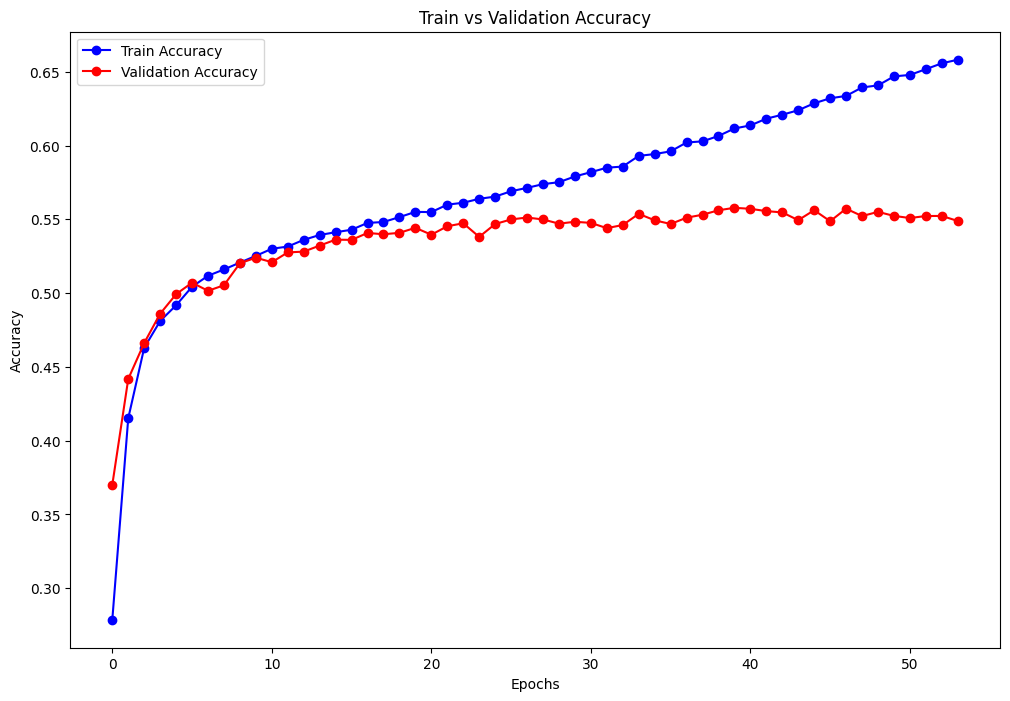

In [9]:
# Extract the train and validation accuracy from the history dictionary
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Get the number of epochs
epochs = range(len(train_accuracy))

# Create a figure with a single subplot
plt.figure(figsize=(12, 8))

# Plot the train and validation accuracy curves
plt.plot(epochs, train_accuracy, 'bo-', label='Train Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')

# Add labels and title
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add legend and show the plot
plt.legend()
plt.show()

In [10]:
test_loss, test_accuracy = gru_model.evaluate(X_test, y_test, verbose = 1)

1375/1375 [==============================] - 8s 6ms/step - loss: 1.2166 - accuracy: 0.5526


1375/1375 [==============================] - 7s 5ms/step


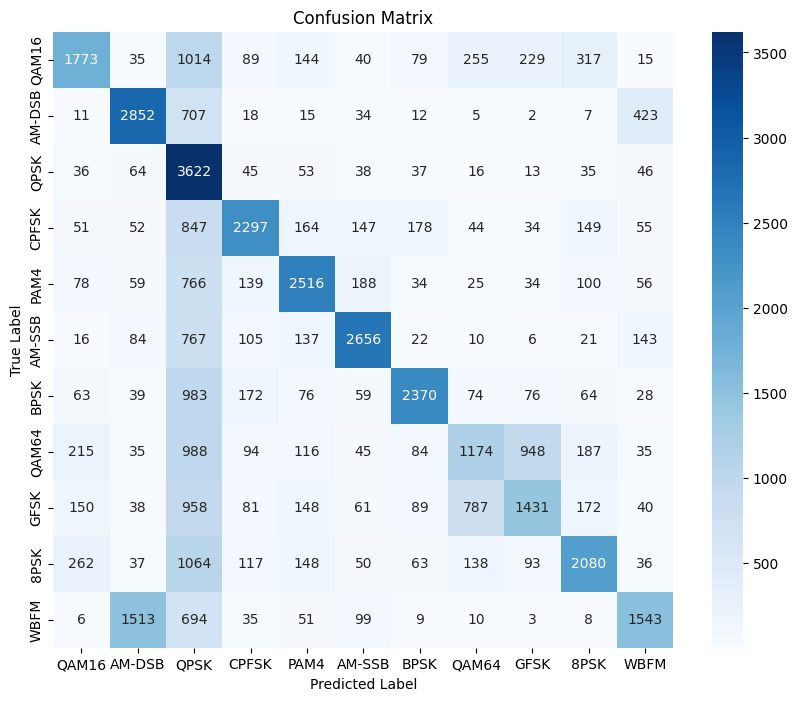

In [11]:
predictions = gru_model.predict(X_test)

# Define the string representations for each label
modulation_labels = ['QAM16', 'AM-DSB', 'QPSK', 'CPFSK', 'PAM4', 'AM-SSB', 'BPSK', 'QAM64', 'GFSK', '8PSK', 'WBFM']

# Convert true labels from one-hot encoded to integer labels
y_test_labels = [np.argmax(label) for label in y_test]

# Convert model predictions to integer labels
predicted_labels = [np.argmax(prediction) for prediction in predictions]

# Convert integer labels to string representations
y_test_labels = [modulation_labels[label] for label in y_test_labels]
predicted_labels = [modulation_labels[label] for label in predicted_labels]

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_labels, predicted_labels, labels=modulation_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=modulation_labels, yticklabels=modulation_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [12]:
# Calculate accuracy for each modulation type
modulation_accuracy = {}
for label, predicted in zip(y_test_labels, predicted_labels):
    if label not in modulation_accuracy:
        modulation_accuracy[label] = []
    modulation_accuracy[label].append(label == predicted)

# Print accuracy for each modulation type
for label, accuracy in modulation_accuracy.items():
    print(f"{label}: {np.mean(accuracy):.2f}")

WBFM: 0.39
AM-DSB: 0.70
BPSK: 0.59
QPSK: 0.90
8PSK: 0.51
QAM64: 0.30
CPFSK: 0.57
AM-SSB: 0.67
PAM4: 0.63
GFSK: 0.36
QAM16: 0.44


In [13]:
# Compute accuracy at each SNR level
snr_labels = np.unique(X_test_snr)
accuracy_by_snr = {}
for snr in snr_labels:
    # Select indices for samples with the current SNR
    snr_indices = np.where(X_test_snr == snr)[0]
    # Get predictions and true labels for the current SNR
    snr_predictions = predictions[snr_indices]
    snr_true_labels = y_test[snr_indices]
    # Convert true labels from one-hot encoded to integer labels
    snr_true_labels = np.argmax(snr_true_labels, axis=1)
    # Compute accuracy for the current SNR
    snr_accuracy = np.mean(np.argmax(snr_predictions, axis=1) == snr_true_labels)
    accuracy_by_snr[snr] = snr_accuracy

# Sort the SNRs and print the accuracy for each
sorted_snrs = np.sort(snr_labels)
for snr in sorted_snrs:
    print(f"SNR: {snr} dB, Accuracy: {accuracy_by_snr[snr]:.2f}")

SNR: -20 dB, Accuracy: 0.10
SNR: -18 dB, Accuracy: 0.10
SNR: -16 dB, Accuracy: 0.13
SNR: -14 dB, Accuracy: 0.15
SNR: -12 dB, Accuracy: 0.18
SNR: -10 dB, Accuracy: 0.25
SNR: -8 dB, Accuracy: 0.31
SNR: -6 dB, Accuracy: 0.40
SNR: -4 dB, Accuracy: 0.53
SNR: -2 dB, Accuracy: 0.64
SNR: 0 dB, Accuracy: 0.73
SNR: 2 dB, Accuracy: 0.79
SNR: 4 dB, Accuracy: 0.84
SNR: 6 dB, Accuracy: 0.84
SNR: 8 dB, Accuracy: 0.85
SNR: 10 dB, Accuracy: 0.84
SNR: 12 dB, Accuracy: 0.85
SNR: 14 dB, Accuracy: 0.85
SNR: 16 dB, Accuracy: 0.84
SNR: 18 dB, Accuracy: 0.84


In [14]:
gru_model.save_weights("/content/drive/MyDrive/Colab_Notebooks/DeepSig/gru_weights.h5")